<a href="https://colab.research.google.com/github/BillWang04/CSE151A-Group-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
business = pd.read_csv('data/business.csv')
economy = pd.read_csv('data/economy.csv')

In [5]:
def clean(df, class_):
    def extract_stops(description):
        stops_match = re.search(r'(\d+)-?stop', description)
        if stops_match:
            return int(stops_match.group(1))
        else:
            return 0
    def duration_to_hours(duration):
        hours, minutes = duration.split('h ')
        hours = float(hours.strip()) if len(hours.strip()) > 1 else 0
        minutes = int(minutes[:-1].strip()) if len(minutes.strip()) > 1 else 0
        total_hours = hours + minutes / 60
        return round(total_hours, 3)
    df_copy = df.copy()
    df_copy["price"] = df_copy["price"].str.replace("," , "").astype(int)
    df_copy["flight_code"] = df_copy["ch_code"].astype(str).str.cat(df_copy["num_code"].astype(str), sep="_")
    df_copy['num_stops'] = df_copy['stop'].apply(extract_stops)
    df_copy["time_taken"] = df_copy["time_taken"].apply(duration_to_hours)
    df_copy['date'] = pd.to_datetime(df_copy['date'], format="%d-%m-%Y")
    df_copy['day_of_week'] = df_copy['date'].dt.dayofweek
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
    df_copy['arr_time'] = df_copy['arr_time'].dt.hour + (df_copy['arr_time'].dt.minute >= 30)
    df_copy['dep_time'] = pd.to_datetime(df_copy['dep_time'])
    df_copy['dep_time'] = df_copy['dep_time'].dt.hour + (df_copy['dep_time'].dt.minute >= 30)
    df_copy = df_copy.drop(columns= ["date", "ch_code", "num_code", "stop"])
    df_copy["class"] = class_
    df_copy = df_copy[["airline", "flight_code", "class", "from", "to", "time_taken", "dep_time", "arr_time", "num_stops", "month", "day_of_week", "price"]]
    return df_copy



In [6]:
cleaned_df = pd.concat([clean(economy, "economy"), clean(business, "business")])
cleaned_df

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
0,SpiceJet,SG_8709,economy,Delhi,Mumbai,2.167,19,21,0,2,4,5953
1,SpiceJet,SG_8157,economy,Delhi,Mumbai,2.333,6,9,0,2,4,5953
2,AirAsia,I5_764,economy,Delhi,Mumbai,2.167,4,7,0,2,4,5956
3,Vistara,UK_995,economy,Delhi,Mumbai,2.250,10,13,0,2,4,5955
4,Vistara,UK_963,economy,Delhi,Mumbai,2.333,9,11,0,2,4,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,Vistara,UK_822,business,Chennai,Hyderabad,10.083,10,20,1,3,3,69265
93483,Vistara,UK_826,business,Chennai,Hyderabad,10.417,13,23,1,3,3,77105
93484,Vistara,UK_832,business,Chennai,Hyderabad,13.833,7,21,1,3,3,79099
93485,Vistara,UK_828,business,Chennai,Hyderabad,10.000,7,17,1,3,3,81585


In [7]:
cleaned_df.describe()

,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
count,300261.000000,300261.000000,300261.00000,300261.000000,300261.000000,300261.000000,300261.000000
mean,12.217291,13.509850,15.80090,0.835703,2.664995,2.954656,20883.717666
std,7.193560,5.412152,6.05027,0.370546,0.471993,2.003251,22695.911266
min,0.333000,0.000000,0.00000,0.000000,2.000000,0.000000,1105.000000
25%,6.750000,9.000000,11.00000,1.000000,2.000000,1.000000,4783.000000
50%,11.250000,13.000000,17.00000,1.000000,3.000000,3.000000,7425.000000
75%,16.167000,19.000000,21.00000,1.000000,3.000000,5.000000,42521.000000
max,49.833000,24.000000,24.00000,1.000000,3.000000,6.000000,123071.000000


Let's first visualize the number of flights by Airline within our dataset.

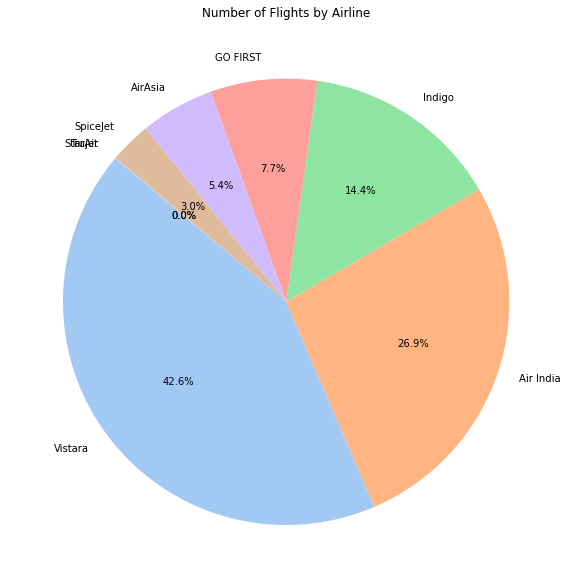

In [8]:
plt.figure(figsize=(10, 15))
airline_counts = cleaned_df['airline'].value_counts()
plt.pie(airline_counts, labels=airline_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Number of Flights by Airline')
plt.show()

In [9]:
cleaned_df['airline'].value_counts()

Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: airline, dtype: int64

It looks like Vistara has by far the most flight data, making up almost half of our dataset, while Trujet and StarAir have very little data (less than 1% of our dataset).

Is there variation in flight prices depending on the day of the week?

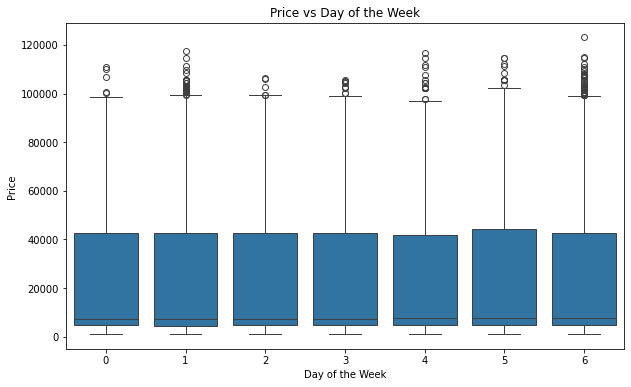

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='price', data=cleaned_df)
plt.title('Price vs Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Price')
plt.show()

It looks like flight prices are generally relatively stable regardless of the day of the week, with similar distributions for each day. However, this does not take into account differences in pricing between different airlines. If we look at a specific airline, Vistara, does this change?

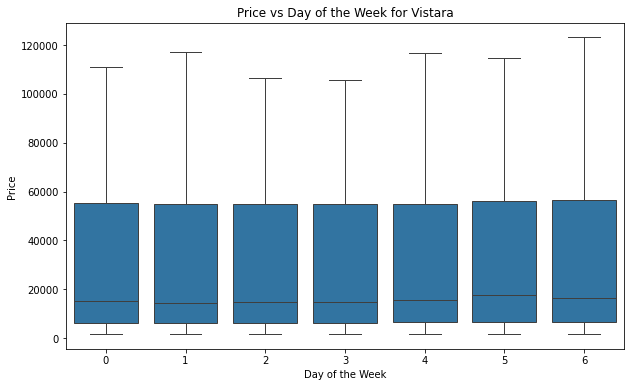

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='price', data=cleaned_df[cleaned_df['airline'] == 'Vistara'])
plt.title('Price vs Day of the Week for Vistara')
plt.xlabel('Day of the Week')
plt.ylabel('Price')
plt.show()

We can see more clearly that the median prices are relatively stable, with the most expensive flights being toward the weekend rather than in the middle of the week. Compared to the combined data for all airlines, we see that the median price for each day is significantly higher (closer to 20000), which indicates that Vistara has generally more expensive flights than other airlines.

We can take a look at the distribution of prices by airline.

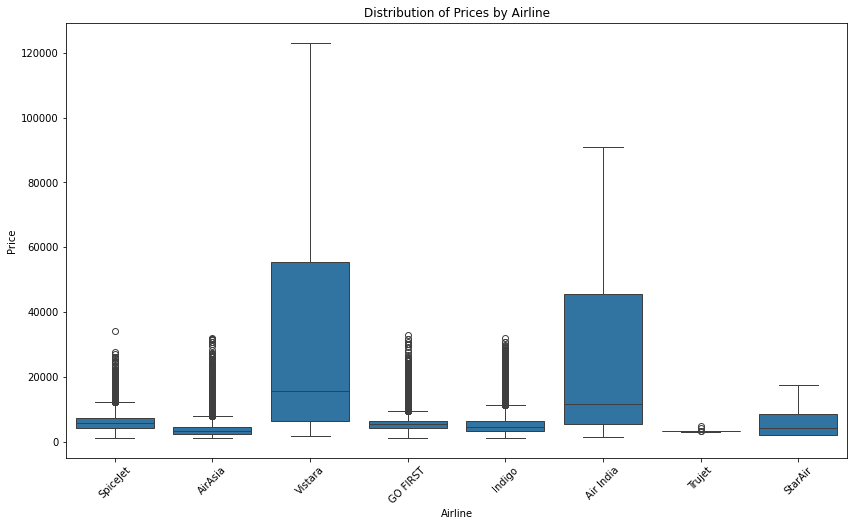

In [12]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='airline', y='price', data=cleaned_df)
plt.title('Distribution of Prices by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

Here, we can see that Vistara and Air India have the most expensive flights, with a larger range of flight prices. For all airlines, the median price is below 20000.

In [13]:
cleaned_df['month'].value_counts()

3    199672
2    100589
Name: month, dtype: int64

It looks like all of our flight data comes from either February or March, and there is more data on flights from March and February.

Let's see if there are any patterns with departure time and pricing.

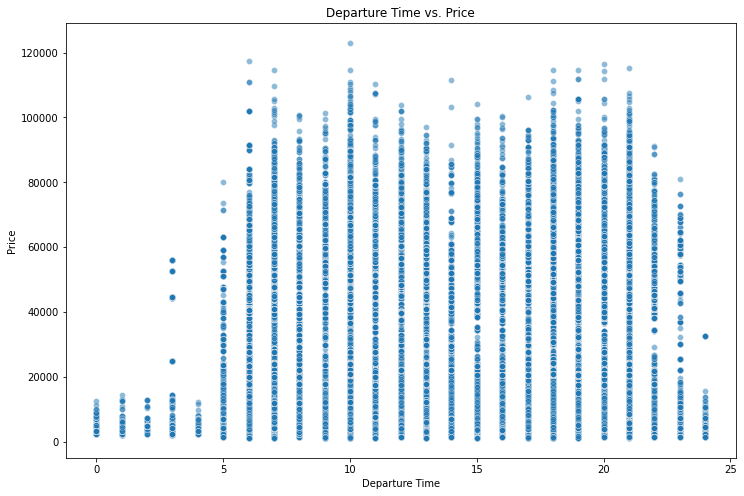

In [14]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='dep_time', y='price', data=cleaned_df, alpha=0.5)
plt.title('Departure Time vs. Price')
plt.xlabel('Departure Time')
plt.ylabel('Price')
plt.show()

We can see that flights the depart between around 11pm-5am are significantly rarer and cheaper than other departure times.

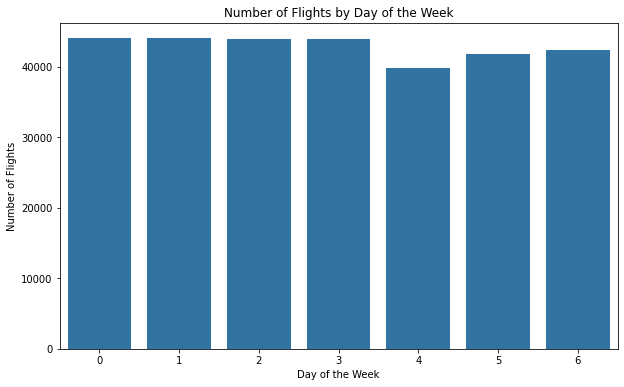

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=cleaned_df)
plt.title('Number of Flights by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.show()

Given this bar chart, it seems that we have around the same amount of flight data for every day of the week.

### PairPlot and Correlation Matrix

In [16]:
cleaned_df.dtypes

airline         object
flight_code     object
class           object
from            object
to              object
time_taken     float64
dep_time         int64
arr_time         int64
num_stops        int64
month            int64
day_of_week      int64
price            int32
dtype: object

<AxesSubplot:>

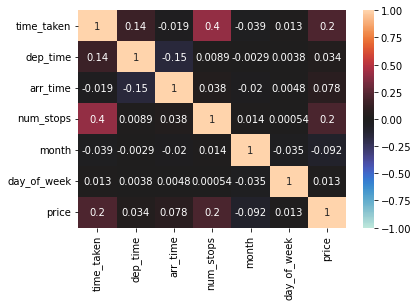

In [17]:
# drop the qualitative data
quantidata = cleaned_df.drop(columns = ['airline','flight_code','class','from','to'])

corr = quantidata.corr()
sns.heatmap(corr, annot = True, vmin=-1,vmax=1,center=0)

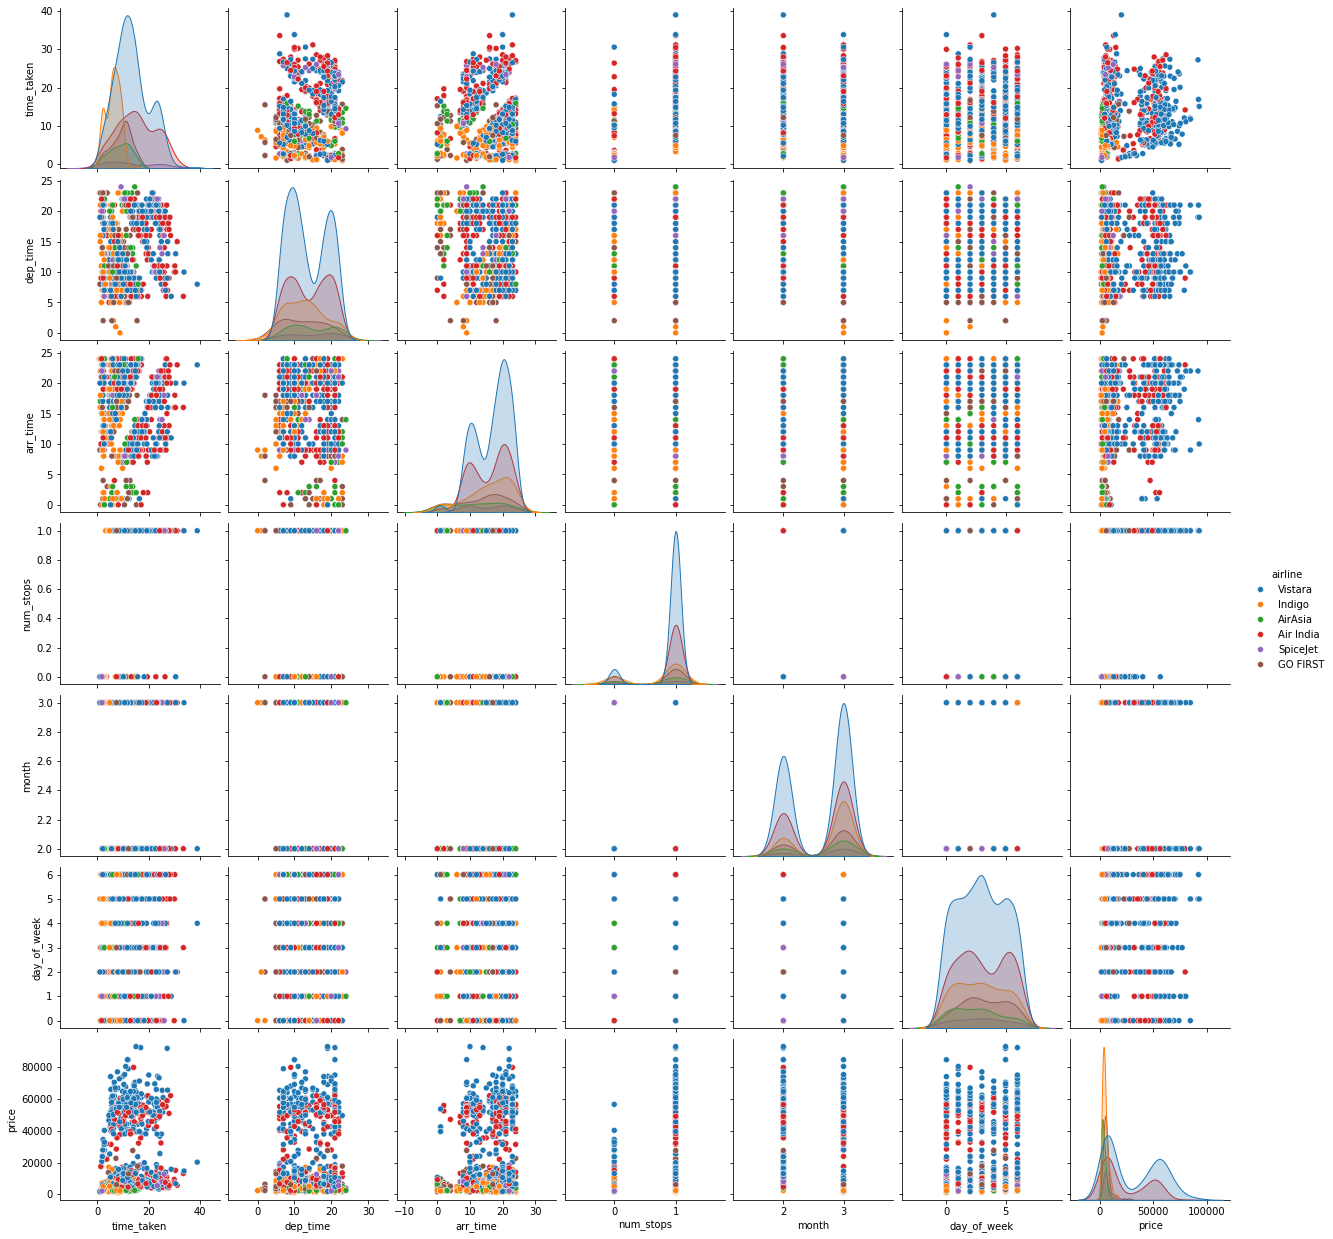

In [18]:
num_samples = 1000
sampled_df = cleaned_df.sample(n=num_samples,random_state=42)
sns.pairplot(sampled_df, hue="airline")

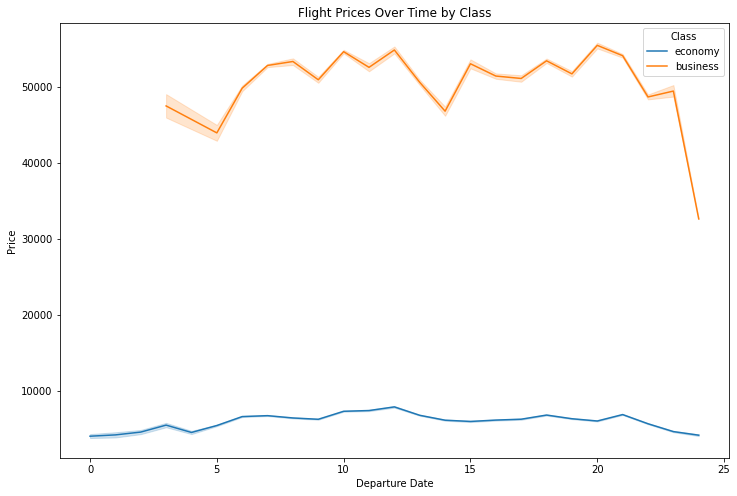

In [19]:
# Create a line plot with separate lines for each class
plt.figure(figsize=(12, 8))
sns.lineplot(data=cleaned_df, x='dep_time', y='price', hue='class')

# Optionally, set additional plot properties
plt.title('Flight Prices Over Time by Class')
plt.xlabel('Departure Date')
plt.ylabel('Price')
plt.legend(title='Class')

# **Preprocess the data**

In [20]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# quantidata = df with only numerical categories
#One Hot Encode (Y)
oneHot = OneHotEncoder()
oneHot_classes = oneHot.fit_transform(cleaned_df.airline.values.reshape(-1,1)).toarray()
y = oneHot_classes

#Normalize the data
#classed_dropped = cleaned_df.drop(columns= ['class', 'airline', 'flight_code', 'from', 'to'])

norm_scaler = MinMaxScaler()
normalized_data = norm_scaler.fit_transform(quantidata)

#Standardize the data
stand_scaler = StandardScaler()
standardized_data = stand_scaler.fit_transform(quantidata)

In [21]:
oneHot_classes[1]

array([0., 0., 0., 0., 1., 0., 0., 0.])

In [22]:
pd.DataFrame(normalized_data)

,0,1,2,3,4,5,6
0,0.037051,0.791667,0.875000,0.0,0.0,0.666667,0.039749
1,0.040404,0.250000,0.375000,0.0,0.0,0.666667,0.039749
2,0.037051,0.166667,0.291667,0.0,0.0,0.666667,0.039773
3,0.038727,0.416667,0.541667,0.0,0.0,0.666667,0.039765
4,0.040404,0.375000,0.458333,0.0,0.0,0.666667,0.039765
...,...,...,...,...,...,...,...
300256,0.196970,0.416667,0.833333,1.0,1.0,0.500000,0.558844
300257,0.203717,0.541667,0.958333,1.0,1.0,0.500000,0.623124
300258,0.272727,0.291667,0.875000,1.0,1.0,0.500000,0.639473
300259,0.195293,0.291667,0.708333,1.0,1.0,0.500000,0.659856


In [23]:
quantidata

,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
0,2.167,19,21,0,2,4,5953
1,2.333,6,9,0,2,4,5953
2,2.167,4,7,0,2,4,5956
3,2.250,10,13,0,2,4,5955
4,2.333,9,11,0,2,4,5955
...,...,...,...,...,...,...,...
93482,10.083,10,20,1,3,3,69265
93483,10.417,13,23,1,3,3,77105
93484,13.833,7,21,1,3,3,79099
93485,10.000,7,17,1,3,3,81585


In [24]:
cleaned_df.airline.value_counts()

Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: airline, dtype: int64

<AxesSubplot:xlabel='time_taken', ylabel='Count'>

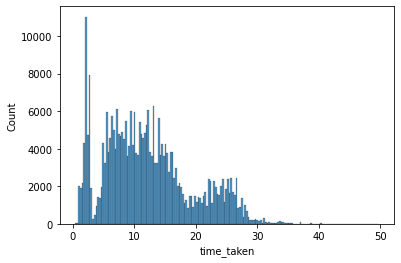

In [25]:
sns.histplot(cleaned_df['time_taken'])

<AxesSubplot:xlabel='time_taken', ylabel='Count'>

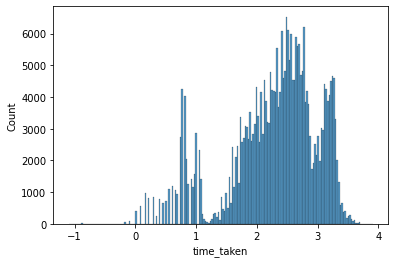

In [26]:
sns.histplot(cleaned_df['time_taken'].apply(np.log))

In [28]:
cleaned_df[cleaned_df['airline'] == 'StarAir']

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
109730,StarAir,S5_151,economy,Bangalore,Hyderabad,1.000,7,8,0,2,5,4337
109764,StarAir,S5_131,economy,Bangalore,Hyderabad,5.083,15,20,1,2,5,11382
110001,StarAir,S5_151,economy,Bangalore,Hyderabad,1.000,7,8,0,2,1,4337
110098,StarAir,S5_131,economy,Bangalore,Hyderabad,5.083,15,20,1,2,1,17482
110430,StarAir,S5_151,economy,Bangalore,Hyderabad,1.000,7,8,0,2,5,4337
...,...,...,...,...,...,...,...,...,...,...,...,...
169904,StarAir,S5_152,economy,Hyderabad,Bangalore,1.083,20,21,0,3,3,2115
169988,StarAir,S5_150,economy,Hyderabad,Bangalore,5.083,9,14,1,3,3,9582
170131,StarAir,S5_152,economy,Hyderabad,Bangalore,1.083,20,21,0,3,5,2115
170514,StarAir,S5_152,economy,Hyderabad,Bangalore,1.083,20,21,0,3,1,2115


In [29]:
cleaned_df.day_of_week.value_counts()

0    44073
1    44041
2    44023
3    44022
6    42399
5    41809
4    39894
Name: day_of_week, dtype: int64

In [30]:
cleaned_df

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
0,SpiceJet,SG_8709,economy,Delhi,Mumbai,2.167,19,21,0,2,4,5953
1,SpiceJet,SG_8157,economy,Delhi,Mumbai,2.333,6,9,0,2,4,5953
2,AirAsia,I5_764,economy,Delhi,Mumbai,2.167,4,7,0,2,4,5956
3,Vistara,UK_995,economy,Delhi,Mumbai,2.250,10,13,0,2,4,5955
4,Vistara,UK_963,economy,Delhi,Mumbai,2.333,9,11,0,2,4,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,Vistara,UK_822,business,Chennai,Hyderabad,10.083,10,20,1,3,3,69265
93483,Vistara,UK_826,business,Chennai,Hyderabad,10.417,13,23,1,3,3,77105
93484,Vistara,UK_832,business,Chennai,Hyderabad,13.833,7,21,1,3,3,79099
93485,Vistara,UK_828,business,Chennai,Hyderabad,10.000,7,17,1,3,3,81585


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

cleaned_df['weekend'] = cleaned_df['day_of_week'] > 4

X_train, X_test, y_train, y_test = train_test_split(cleaned_df.drop(columns=['price']), cleaned_df['price'], test_size=0.2, random_state=69)


prepoc = ColumnTransformer([
    ('airline', OneHotEncoder(handle_unknown='ignore'), ['airline', 'class']), #comment out for baseline
    ('log', FunctionTransformer(lambda x: np.log(x + 0.001)), ['time_taken']), # comment out for baseline
    # ('square', FunctionTransformer(lambda x: x**2), ['RES.PRICE']),
    ('test', FunctionTransformer(lambda x: x), ['dep_time', 'arr_time', 'num_stops', 'weekend']),
    # ('test', FunctionTransformer(lambda x: x), ['TOTAL.PRICE', 'OUTAGE.DURATION']), #baseline
], remainder='drop')

pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', LinearRegression())
    ])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# # Predict on the testing data
predictions = pipe.predict(X_test)



In [32]:
train_predictions = pipe.predict(X_train)

RMSE_test = np.sqrt(np.sum((y_test - predictions)**2) / y_test.shape[0])
np.sqrt(np.sum((y_train - train_predictions)**2) / y_train.shape[0])

7203.887409473035

In [33]:
RMSE_test

7198.631311457379

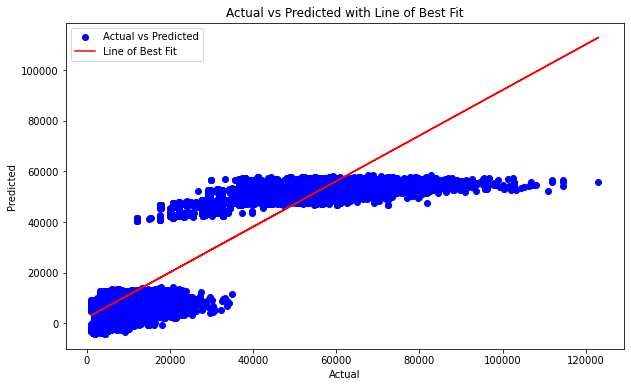

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', label='Actual vs Predicted')

z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red', label='Line of Best Fit')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted with Line of Best Fit')
plt.legend(loc='best')
plt.show()

The next two models we were thinking about using are ridge regression and random forest regression. We are considering ridge regression because it uses regularization to prevent overfitting and penalizes large coefficients to reduce model complexity and improve generalization. Ridge regression is also very useful when dealing with multicollinearity within the features. The second model we were thinking about using is random forest regression because random forest regression is less prone to overfitting, as each tree in the random forest is trained on a random subset of the training data and a random subset of features. Random forest regression is useful for capturing nonlinear relationships between features and the target variable.

 - log transform time taken
 - dont transform any of the other numerical data, especially price as it is bimodal distribution
 - other "numerical" data is more categorical/ordinal than quantitative
 - possibly one hot encode the destination and arrival cities, can do separately or feature engineer them as pairs and one hot encode the pairs
 - maybe add a boolean feature weekend (friday, sat, sun) or not, also is sunday 0 for day_of_week
 - change num_stops to boolean feature (ex. transfer) as there are only 0s and 1s
 - can also change month to cateogry or boolean as only feb and march (2 and 3)